In [31]:
import numpy as np
import pandas as pd
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [32]:
df = pd.read_csv('coffee.csv')
pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [33]:
df = df.drop(columns=['Currency'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2000-01-03,122.25,124.00,116.10,116.50,6640
1,2000-01-04,116.25,120.50,115.75,116.25,5492
2,2000-01-05,115.00,121.00,115.00,118.60,6165
3,2000-01-06,119.00,121.40,116.50,116.85,5094
4,2000-01-07,117.25,117.75,113.80,114.15,6855


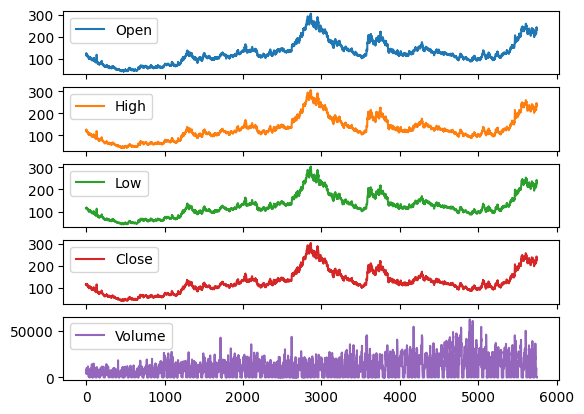

In [34]:
plot_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [41]:
data = df[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(len(train), len(test))

3849 1897


In [68]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [69]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [71]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=20, activation='relu', 
            return_sequences=True, input_shape=(1, look_back)))
lstm_model.add(LSTM(units=20, activation='relu', 
            return_sequences=True))
lstm_model.add(Dense(units=1))

print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 20)             1760      
                                                                 
 lstm_11 (LSTM)              (None, 1, 20)             3280      
                                                                 
 dense_5 (Dense)             (None, 1, 1)              21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
3847/3847 [==============================] - 6s 1ms/step - loss: 0.0086
Epoch 2/10
3847/3847 [==============================] - 5s 1ms/step - loss: 2.4330e-04
Epoch 3/10
3847/3847 [==============================] - 5s 1ms/step - loss: 1.9492e-04
Epoch 4/10
3847/3847 [==============================] - 6s 1ms/step - loss: 1.8860e-04
Epoch 5/10
3847/3847 [==============================] - 6s 1ms/step - loss: 1.7432e-04
Epoch 6/10
3847/3847 [==============================] - 5s 1ms/step - loss: 1.8170e-04
Epoch 7/10
3847/3847 [==============================] - 5s 1ms/step - loss: 1.7797e-04
Epoch 8/10
3847/3847 [==============================] - 5s 1ms/step - loss: 1.6916e-04
Epoch 9/10
3847/3847 [==============================] - 5s 1ms/step - loss: 1.6674e-04
Epoch 10/10
3847/3847 [==============================] - 5s 1ms/step - loss: 1.6706e-04


In [74]:
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

trainPredict = np.reshape(trainPredict, (trainPredict.shape[0], trainPredict.shape[1]))
testPredict = np.reshape(testPredict, (testPredict.shape[0], testPredict.shape[1]))


60/60 [==============================] - 0s 916us/step


In [75]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [76]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

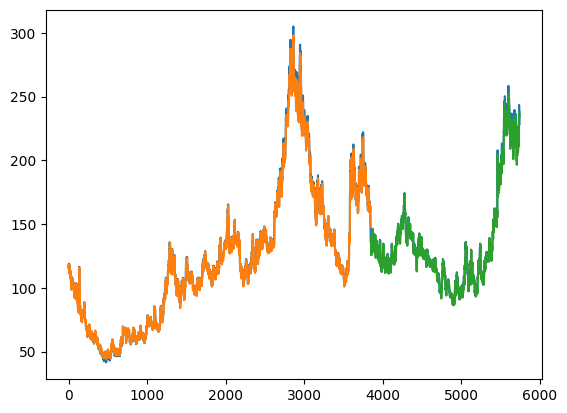

In [80]:
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()